# Problème du voyageur de commerce

### Groupe 3

Angel URIOT et Arthur AZAMBRE

### Importation des librairies

In [1]:
import cplex
import numpy as np
import matplotlib.pyplot as plt

### Paramètres

In [2]:
NB_CITIES = 30 # Number of cities
STOCHASTIQUE = False # If True, use stochastic model

### Villes

$
G = (V, E) \text{ un graphe orienté complet de } n \text{ sommets}
$
<br/>

$
\text{En pratique on génère N villes dans un carré de côté 1}
$

In [3]:
cities = np.random.uniform(0., 1., (NB_CITIES, 2))

$
\text{On crée une fonction qui affiche les villes sur un graphique et donne la longueur totale du chemin}
$

In [4]:
def plot(cities, path = None):

	cities = np.array(cities)
	path_length = 0

	# Plot the paths
	if path is None:
		for i in range(NB_CITIES - 1):
			plt.plot(cities[[i, i + 1], 0], cities[[i, i + 1], 1], color = 'red')
			path_length += np.linalg.norm(cities[i] - cities[i + 1])
	else:
		path = np.array(path)
		for p in path:
			plt.plot(p[:, 0], p[:, 1], color = 'red')
			path_length += np.linalg.norm(p[0] - p[1])

	# Print the path length
	print('Longueur du chemin : {:f}'.format(path_length))

	# Plot the cities
	plt.plot(cities[:, 0], cities[:, 1], 'o', color = 'black')

	# Axis
	plt.xlim(-0.01, 1.01)
	plt.ylim(-0.01, 1.01)
	plt.gca().set_aspect('equal', adjustable = 'box')
	plt.axis('off')

	# Show
	plt.show()

Longueur du chemin : 16.003138


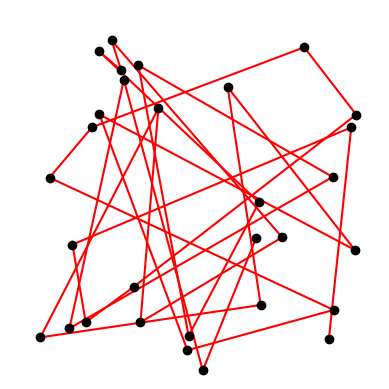

In [5]:
plot(cities)

$
c_{ij} \text{ est le coût de l'arc } (v_i, v_j)
$

In [6]:
cost = []

for i in range(NB_CITIES):
	cost.append([])
	for j in range(NB_CITIES):
		cost[i].append(np.linalg.norm(cities[i] - cities[j]))

cost = np.array(cost)

### Création du modèle

In [7]:
model = cplex.Cplex()

### Variables de décision

$
x_{ij} = \left \{ \begin{array}{ll} 1 & \text{si et seulement si l'arc } (v_i, v_j) \text{ est retenu dans le circuit,} \\ 0 & \text{sinon} \end{array} \right .
$

$
u_i \text{ est une variable de décision nécessaire à la contrainte d'élimination des sous-circuits}
$

In [8]:
model.variables.add(
	names = ["x_" + str(i) + "_" + str(j) for j in range(NB_CITIES) for i in range(NB_CITIES)],
	obj = [cost[i][j] for j in range(NB_CITIES) for i in range(NB_CITIES)],
	lb = [0] * (NB_CITIES ** 2),
	ub = [1] * (NB_CITIES ** 2),
	types = ["B"] * (NB_CITIES ** 2)
)

model.variables.add(
	names = ["u_" + str(i) for i in range(NB_CITIES)],
	obj = [0] * NB_CITIES,
	lb = [0] * NB_CITIES,
	ub = [cplex.infinity] * NB_CITIES,
	types = ["C"] * NB_CITIES
)

range(900, 930)

### Fonction objectif

$$
\underset{x}{min} \left \{ \sum_{i=1}^{n} \sum_{j=1}^{n} \overline{c}_{ij} x_{ij} \right \} \quad \quad x_{ij} \in \{0, 1\}, \quad \quad 1 \leq i, j \leq n
$$

In [9]:
model.objective.set_sense(model.objective.sense.minimize)

### Contrainte obligeant le circuit à passer par toutes les villes

$$
\sum_{i \neq j, j=1}^{n} x_{ij} = 1, \quad \quad i = 1, \ldots, n \quad \quad (1a)
$$

In [10]:
for i in range(NB_CITIES):

	temp = []

	for j in range(NB_CITIES):
		if i != j:
			temp.append("x_" + str(i) + "_" + str(j))

	model.linear_constraints.add(lin_expr = [[temp, [1] * len(temp)]], senses = ["E"], rhs = [1])

### Contrainte obligeant le circuit à passer par toutes les villes

$$
\sum_{i \neq j, i=1}^{n} x_{ij} = 1, \quad \quad j = 1, \ldots, n \quad \quad (1b)
$$

In [11]:
for j in range(NB_CITIES):

	temp = []

	for i in range(NB_CITIES):
		if i != j:
			temp.append("x_" + str(i) + "_" + str(j))

	model.linear_constraints.add(lin_expr = [[temp, [1] * len(temp)]], senses = ["E"], rhs = [1])

### Contrainte d'élimination des sous-circuits

$
\text{Théorie :}
$

$$
\sum_{i \mid v_i \in S}^{} \sum_{j \mid v_j \in S}^{} x_{ij} \leq |S| - 1, \quad \quad S \subset \{v_1, \ldots, v_n\} \text{ et } S \neq \varnothing, \quad \quad (1c)
$$

<br/>

$
\text{En pratique (méthode simplifiée) :}
$

$$
u_i + x_{ij} \leq u_j + (n - 1) (1 - x_{ij}), \quad \quad i = 1, \ldots, n, \quad \quad j = 2, \ldots, n \quad \quad i \neq j
$$

$$
\Leftrightarrow
$$

$$
u_i - u_j + n x_{ij} \leq n - 1, \quad \quad i = 1, \ldots, n, \quad \quad j = 2, \ldots, n \quad \quad i \neq j
$$

In [12]:
for i in range(NB_CITIES):
	for j in range(1, NB_CITIES):
		if i != j:
			model.linear_constraints.add(
				lin_expr = [[["u_" + str(i), "u_" + str(j), "x_" + str(i) + "_" + str(j)], [1, -1, NB_CITIES]]],
				senses = ["L"],
				rhs = [NB_CITIES - 1]
			)
		else:
			model.linear_constraints.add(
				lin_expr = [[["x_" + str(i) + "_" + str(j)], [NB_CITIES]]],
				senses = ["L"],
				rhs = [NB_CITIES - 1]
			)

### Contrainte stochastique

$
\text{Soit : } \tilde{c} \sim \mathcal{N}(\mu, \sigma)
$

$$
\mathbb{P} \left \{ \sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij} \leq Z \right \} \geq \alpha \quad \quad (1d)
$$

$
\text{Soit : } h = \sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij} - Z
$

$$
\mathbb{P} \left \{ h \leq 0 \right \} \geq \alpha
$$

$
\text{On cherche l'espérance } E(h) \text{ et la variance } Var(h) \text{ de } h :
$

$$
E(h) = E(\sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij} - Z)
$$

$$
= E(\sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij}) - Z
$$

$$
= \sum_{i=1}^{n} \sum_{j=1}^{n} E(\tilde{c}_{ij}) x_{ij} - Z
$$

$$
= \sum_{i=1}^{n} \sum_{j=1}^{n} \mu_{ij} x_{ij} - Z
$$

<br/>

$$
Var(h) = Var(\sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij} - Z)
$$

$$
= Var(\sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{c}_{ij} x_{ij})
$$

$$
= \sum_{i=1}^{n} \sum_{j=1}^{n} Var(\tilde{c}_{ij}) x_{ij}²
$$

$$
= \sum_{i=1}^{n} \sum_{j=1}^{n} \sigma² x_{ij}²
$$

<br/>

$
\text{Soit } s \text{ un seuil de tolérance, on cherche :}
$

$$
E(h) - s \sqrt{Var(h)} \leq 0
$$

$$
\sum_{i=1}^{n} \sum_{j=1}^{n} \mu_{ij} x_{ij} - Z - s \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} \sigma² x_{ij}²} \leq 0
$$

<br/>

$
\text{Pour simplifier, on pose } \mu_{ij} = \mu \text{ et } \sigma_{ij}² = \sigma² \text{, on obtient :}
$

$$
\mu \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} - Z - s \sigma \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij}²} \leq 0
$$

$$
\Leftrightarrow \mu \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} - Z \leq s \sigma \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij}²}
$$

$$
\Leftrightarrow \left ( \mu \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} - Z \right )² \leq \left ( s \sigma \sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij}²} \right )²
$$

$$
\Leftrightarrow \mu² \left ( \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} \right )² - 2 Z \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} + Z² \leq s² \sigma² \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij}²
$$

<br/>

$
x_{ij} \in \{0, 1\} \text{ donc on peut simplifier en posant } x_{ij}² = x_{ij} \text{ :}
$

$$
\Leftrightarrow \mu² \left ( \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} \right )² - 2 Z \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} + Z² \leq s² \sigma² \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij}
$$

<br/>

$
\text{Cplex ne gère que les contraintes linéaires, il reste donc encore l'expression } \left ( \sum_{i=1}^{n} \sum_{j=1}^{n} x_{ij} \right )² \text{ à simplifier.}
$

In [13]:
if STOCHASTIQUE:

	for i in range(NB_CITIES):
		if i != j:
			model.linear_constraints.add(
				lin_expr = [[[], []]],
				senses = [],
				rhs = []
			)

### Résolution

In [14]:
model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 29 rows and 31 columns.
MIP Presolve modified 58 coefficients.
Reduced MIP has 901 rows, 899 columns, and 4234 nonzeros.
Reduced MIP has 870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.25 ticks)
Probing time = 0.00 sec. (2.56 ticks)
Cover probing fixed 0 vars, tightened 29 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 29 rows and 0 columns.
Reduced MIP has 872 rows, 899 columns, and 4176 nonzeros.
Reduced MIP has 870 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.88 ticks)
Probing time = 0.00 sec. (2.56 ticks)
Clique table members: 466.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (1.64 ticks)

        No

### Résultats

Longueur du chemin : 3.990161


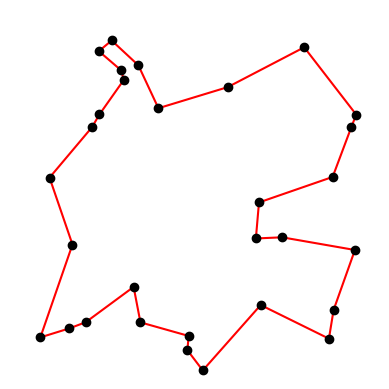

In [15]:
result = model.solution.get_values()

paths = []

for i in range(NB_CITIES):
	for j in range(NB_CITIES):
		if result[i * NB_CITIES + j] == 1:
			paths.append([cities[i], cities[j]])

plot(cities, paths)